In [1]:
import joblib
import pickle
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

# Import logistic regression models and data

In [2]:
# load model, pipe, threhsolds and labels
payload = joblib.load("methods_paper_files/results/final_lr_model.pkl")
pipe       = payload['pipeline']
thresholds = np.array(payload['thresholds'])
label_names = payload['label_names']

In [4]:
# all paras
filename = "methods_paragraph_corpus.pickle"
with open(filename, "rb") as f:
    methods_paras = pickle.load(f)

# load list with categories of interest
filename = "categories_of_interest.txt"
with open(filename, 'r') as file:
    cats = json.load(file)

# hierarchical classification of the categories
filename = "classification_categories.txt"
with open(filename, "r") as file:
    classif = json.load(file)

# annotated data
df = pd.read_csv("testData13052025.csv")
df = df.drop(columns = 'Unnamed: 0')

# all paras in a df, without annotated
df_to_predict = pd.DataFrame([{key:methods_paras[key] for key in methods_paras.keys()}]).T # in case you want without the annotated ones, add "if key not in df.id.values"
df_to_predict.columns = ['text']

df_to_predict.head()

,text
./Corpus/Zootaxa/7/zootaxa_7_1_1.json_0,Pupal exuviae were collected with a Brundin ne...
./Corpus/Zootaxa/7/zootaxa_7_1_1.json_1,Specimens were mounted on slides in Canada Bal...
./Corpus/Zootaxa/9/zootaxa_9_1_1.json_0,During July and August 2000 grass samples were...
./Corpus/Zootaxa/9/zootaxa_9_1_1.json_1,Measurements of mites were made according to A...
./Corpus/Zootaxa/1/zootaxa_10_1_1.json_0,Table 1 reports\ngeneral information on the po...


In [5]:
# function to infer labels from other labels
# this includes broader levels in the hierarchy from leave nodes, but also related labels (such 'phylogenetic' from 'phylo_sd')
def propagate_hierarchy(pred_df, classif):
    """Return a copy where every parent/cross-link label is made 1
       if any of its children are 1."""
    out = pred_df.copy()

    def recurse(node):
        if isinstance(node, dict):
            for parent, children in node.items():
                recurse(children)
                child_keys = []
                for c in children:
                    if isinstance(c, str):
                        child_keys.append(c)
                    elif isinstance(c, dict):
                        child_keys.extend(c.keys())
                if child_keys:
                    out.loc[out[child_keys].eq(1).any(axis=1), parent] = 1
        elif isinstance(node, list):
            for item in node:
                recurse(item)

    recurse(classif)

    # cross-links outside the hierarchical classification
    if {'interbr_morph','gen_interbr','interbreeding'}.issubset(out):
        mask = (out.interbr_morph==1)|(out.gen_interbr==1)
        out.loc[mask, 'interbreeding'] = 1

    if {'distance_based','distance'}.issubset(out):
        out.loc[out.distance_based==1, 'distance'] = 1

    if {'phen_pylo','phylo_sd','phylo_tree','phylogenetic'}.issubset(out):
        mask = (out.phen_pylo==1)|(out.phylo_sd==1)|(out.phylo_tree==1)
        out.loc[mask, 'phylogenetic'] = 1

    return out


# function to flatten the hierarchical classification
def flatten(node):
    """Return a list of all string keys/leaves in the (nested) node."""
    if isinstance(node, str):
        return [node]
    elif isinstance(node, dict):
        out = []
        for k, v in node.items():
            out.append(k)
            out.extend(flatten(v))
        return out
    elif isinstance(node, list):
        out = []
        for item in node:
            out.extend(flatten(item))
        return out
    else:
        return []

# extract label lists for three top‑level branches
phen_labels = flatten(classif['phenotype'])
geno_labels = flatten(classif['genotype'])
single_labels = classif['singletons']  # already a flat list

# Predict

In [7]:
# texts that we want to assign labels to
new_texts = df_to_predict['text']

# Convert the new texts into feature vectors using the trained vectorizer
X_new_feats = pipe.named_steps['vect'].transform(new_texts)

# Get predicted class probabilities from the trained classifier
prob_new   = pipe.named_steps['clf'].predict_proba(X_new_feats)

# Convert probabilities to binary predictions based on thresholds
y_new_hat   = (prob_new >= thresholds).astype(int)

# Put the predictions into a DataFrame with proper column (label) names
df_new_hat  = pd.DataFrame(y_new_hat, columns=label_names)

# Enforce hierarchical consistency between labels, then fill missing values with 0 and convert to int
df_new_hat  = propagate_hierarchy(df_new_hat, classif).fillna(0).astype(int)

# add indices, paper and texts to the resulting df
df_new_hat['text'] = new_texts.values
df_new_hat.index = df_to_predict.index
df_new_hat['paper'] = [i.split('.json')[0] for i in df_new_hat.index]

df_new_hat.head()

,phenotype,phen_data,morph,biogeo,color_pattern,phen_proc,imaging,quant_morph,storage,sampling,...,phen_pylo,distance_based,acoustic,phylo_sd,interbreeding,specimen_storage_loc,abbrev_terms,singletons,text,paper
./Corpus/Zootaxa/7/zootaxa_7_1_1.json_0,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,Pupal exuviae were collected with a Brundin ne...,./Corpus/Zootaxa/7/zootaxa_7_1_1
./Corpus/Zootaxa/7/zootaxa_7_1_1.json_1,1,1,1,0,0,1,1,0,1,0,...,0,0,0,0,0,0,0,0,Specimens were mounted on slides in Canada Bal...,./Corpus/Zootaxa/7/zootaxa_7_1_1
./Corpus/Zootaxa/9/zootaxa_9_1_1.json_0,1,1,1,0,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,During July and August 2000 grass samples were...,./Corpus/Zootaxa/9/zootaxa_9_1_1
./Corpus/Zootaxa/9/zootaxa_9_1_1.json_1,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,Measurements of mites were made according to A...,./Corpus/Zootaxa/9/zootaxa_9_1_1
./Corpus/Zootaxa/1/zootaxa_10_1_1.json_0,1,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,Table 1 reports\ngeneral information on the po...,./Corpus/Zootaxa/1/zootaxa_10_1_1


# Make a paper level df

In [8]:
df_new_hat_paper = (
    df_new_hat
    .groupby('paper')[cats]
    .max()
    .reset_index()
)

print(df_new_hat_paper.shape)
df_new_hat_paper.head()

(28312, 39)


,paper,phenotype,phen_data,morph,biogeo,color_pattern,phen_proc,imaging,quant_morph,storage,...,behav,phylogenetic,rank_just,phen_pylo,distance_based,acoustic,phylo_sd,interbreeding,specimen_storage_loc,abbrev_terms
0,./Corpus/EJT/10_5852_ejt_2011_2,1,1,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
1,./Corpus/EJT/10_5852_ejt_2011_3,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,1,1,1
2,./Corpus/EJT/10_5852_ejt_2012_11,1,1,1,1,0,1,1,1,1,...,0,0,1,0,0,0,0,1,1,1
3,./Corpus/EJT/10_5852_ejt_2012_12,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
4,./Corpus/EJT/10_5852_ejt_2012_13,1,1,1,1,1,1,0,1,0,...,0,0,1,0,0,0,0,1,1,0


In [80]:
filepath = 'methods_full_corpus_prediction.csv'
df_new_hat_paper.to_csv(filepath, sep = ';', index=False)

# look at the data

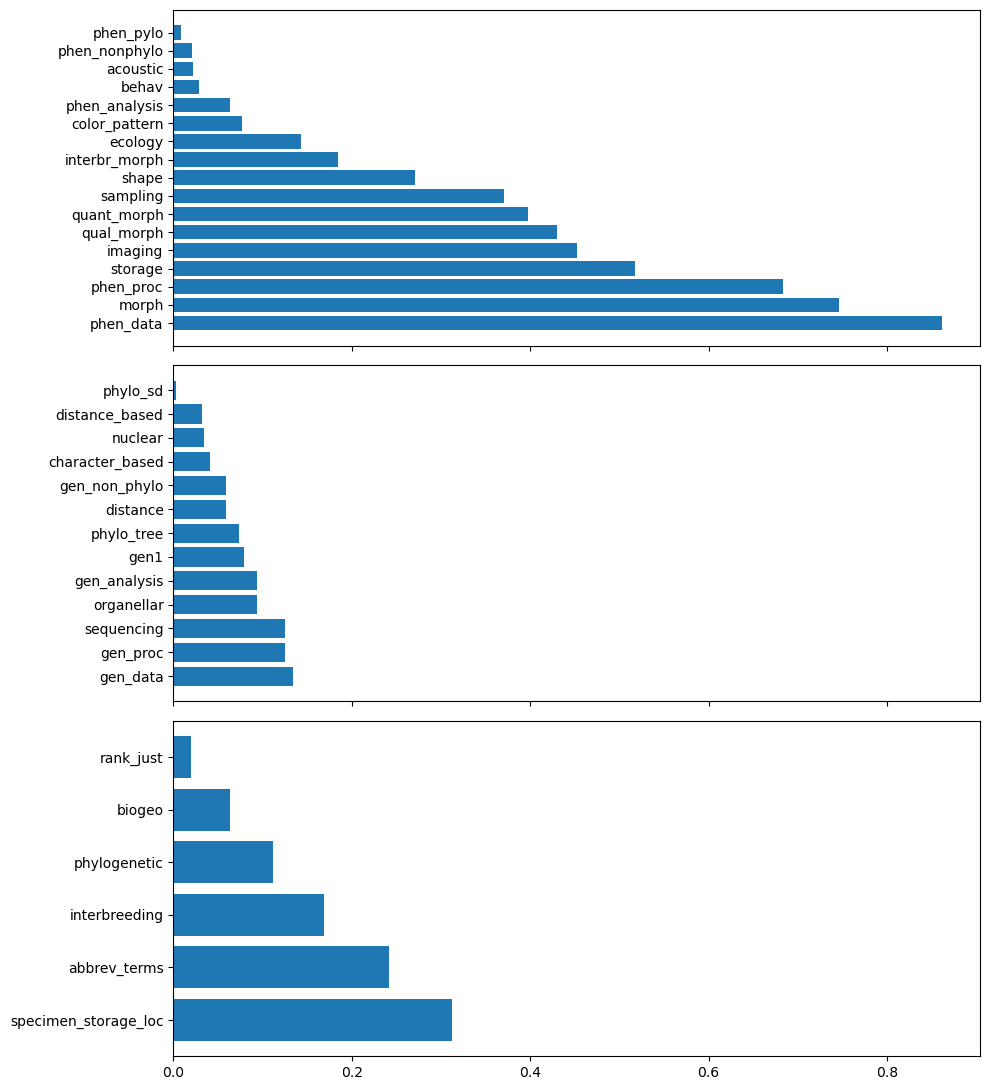

In [44]:
fig, axs = plt.subplots(nrows = 3, figsize = (10, 11), sharex=True)

for group, ax in zip([phen_labels, geno_labels, single_labels], axs.flat):
    freqs = pd.Series(df_new_hat[group].sum() / len(df_new_hat)).sort_values(ascending = False)
    ax.barh(y= freqs.index, width=freqs.values)


fig.tight_layout()

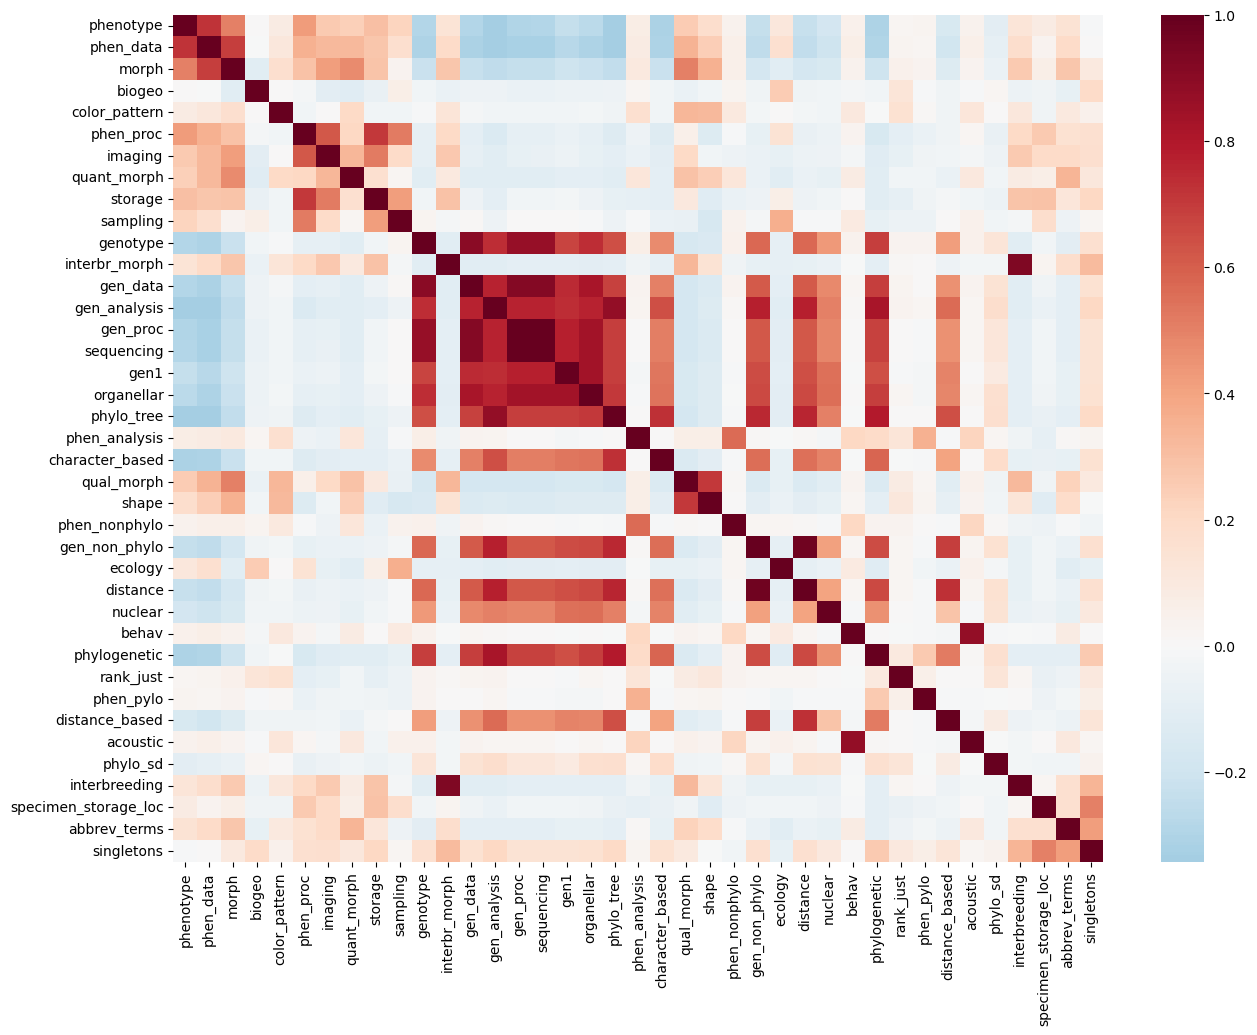

In [61]:
import seaborn as sns

corr = df_new_hat[df_new_hat.columns[:-1]].corr()                         # compute correlations
plt.figure(figsize=(15,11))             # adjust size as needed
sns.heatmap(corr, annot=False, cmap="RdBu_r", center=0)
plt.show()